In [2]:
import numpy as np
import h5py
import os

In [5]:
import sys
sys.path.append('../src/')

In [16]:
# Import PCA functions
from pca import PCA

In [10]:
# Import utils function
from utils import load_model, dot_dict

#### 1. Load Petrel Models

In [8]:
data_dir = './data'

In [11]:
args = {}
args['m_petrel'] = os.path.join(data_dir, 'm_petrel_train3000_case1.h5')  # Petrel training models
args = dot_dict(args)

In [14]:
# Load m_petrel
m_petrel = load_model(args.m_petrel).astype(np.float32)
m_petrel.shape

(3000, 40, 60, 60, 1)

In [15]:
nr, nz, nx, ny, _ = m_petrel.shape
m_petrel.shape

(3000, 40, 60, 60, 1)

#### 2. Construct PCA

In [17]:
pca_model = PCA(nc=nx*ny*nz, nr=nr, l=3000)

In [19]:
pca_model.construct_pca(m_petrel.reshape((nr, nx*ny*nz)).T)

In [20]:
pca_model.usig.shape

(144000, 3000)

In [21]:
pca_model.sig.shape

(3000, 1)

#### 3. Plot Relative Energy

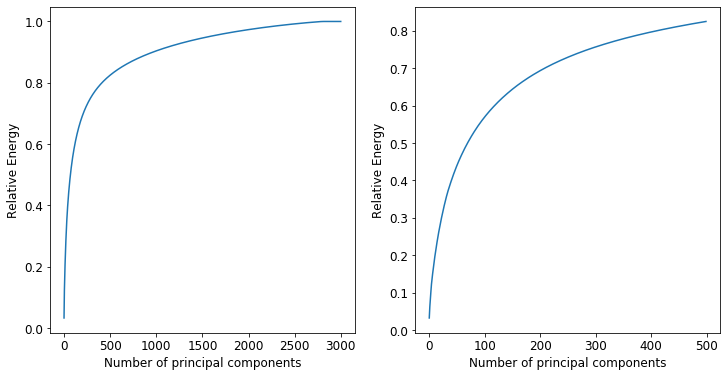

In [22]:
cum_energy = np.cumsum(pca_model.sig**2)
rel_energy = cum_energy / cum_energy[-1]

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(rel_energy)
plt.ylabel('Relative Energy')
plt.xlabel('Number of principal components')
plt.subplot(1,2,2)
plt.plot(rel_energy[:500])
plt.ylabel('Relative Energy')
plt.xlabel('Number of principal components')
plt.show()

In [23]:
print('The first 400 principal components explains %.1f percent of energy' % (100*rel_energy[400]))

The first 400 principal components explains 79.7 percent of energy


#### 4. Generate Reconstructed PCA models for Training

In [30]:
np.random.seed(1234567)

In [35]:
dim = 400

In [36]:
# Project Petrel models onto principal components
xi_rec = pca_model.get_xi(m_petrel.reshape((nr, nx*ny*nz)).T, dim=dim)
xi_rec.shape

(400, 3000)

In [37]:
# Perturb xi
perb_dim = 30
xi_rec[perb_dim:, :] += np.random.normal(size=(dim-perb_dim, 3000))

In [47]:
# Generate reconstructed pca models
m_pca_rec = pca_model.generate_pca_realization(xi_rec, dim=dim).T
m_pca_rec = m_pca_rec.reshape((nr, nz, nx, ny, 1))
m_pca_rec.shape

(3000, 40, 60, 60, 1)

#### 5. Generate New PCA Models for Training

In [48]:
xi = np.random.normal(0,1,(dim, nr))
m_pca = pca_model.generate_pca_realization(xi, dim).T
m_pca = m_pca.reshape((nr, nz, nx, ny, 1))
m_pca.shape

(3000, 40, 60, 60, 1)

#### 6. Generate Test PCA Models

In [43]:
np.random.seed(1239879861)

In [53]:
ntest = 200
xi_test = np.random.normal(0,1,(dim, ntest))
m_pca_test = pca_model.generate_pca_realization(xi_test, dim).T
m_pca_test = m_pca_test.reshape((ntest, nz, nx, ny, 1))
m_pca_test.shape

(200, 40, 60, 60, 1)

#### 7. Save models to file

In [50]:
fn = h5py.File(os.path.join(data_dir,'m_pca_train3000_case1.h5'), 'w')
fn.create_dataset('data', data=m_pca.astype('float16'))
fn.close()

In [52]:
fn = h5py.File(os.path.join(data_dir,'m_pca_rec_train3000_case1.h5'), 'w')
fn.create_dataset('data', data=m_pca_rec.astype('float16'))
fn.close()

In [54]:
fn = h5py.File(os.path.join(data_dir,'m_pca_test200_case1.h5'), 'w')
fn.create_dataset('data', data=m_pca_test.astype('float16'))
fn.close()

In [55]:
exit()